In [1]:
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Micuminc_conf_prob_onset.csv')
df = df.set_index('Date')
df = df.iloc[:, 1:-23]

# Convert cumulative cases to daily new cases
df = df.diff().fillna(0)

wash = df['Washtenaw'][180:300]

In [3]:
hosp_df = pd.read_csv('covid_hosp_report_clinical.csv')

hosp = hosp_df.pivot_table(
    index='Date', 
    columns='County', 
    values='total_adult_suspected_confirmed', 
    aggfunc='sum'  # You can change this to 'mean' or another function as needed
).fillna(0)

wash_hosp = hosp['Washtenaw']

wash_hosp = wash_hosp[:116].to_numpy()
wash_hosp = np.concatenate((np.zeros(4), wash_hosp))

wash_hosp[1] = 20.0
wash_hosp[2] = 30.0
wash_hosp[3] = 40.0

In [4]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.stats import poisson, norm
import warnings
warnings.filterwarnings('ignore')

class SIRHModel:
    def __init__(self, population_size=367600):  # Washtenaw County population
        self.N = population_size
        
    def sirh_equations(self, y, t, beta, gamma, delta, alpha):
        """
        SIRH model differential equations
        
        Parameters:
        - beta: transmission rate
        - gamma: recovery rate from I to R
        - delta: hospitalization rate from I to H
        - alpha: recovery/discharge rate from H to R
        """
        S, I, R, H = y
        
        dSdt = -beta * S * I / self.N
        dIdt = beta * S * I / self.N - gamma * I - delta * I
        dRdt = gamma * I + alpha * H
        dHdt = delta * I - alpha * H
        
        return [dSdt, dIdt, dRdt, dHdt]
    
    def simulate(self, t, params, initial_conditions):
        """Simulate the SIRH model"""
        beta, gamma, delta, alpha = params
        sol = odeint(self.sirh_equations, initial_conditions, t, args=(beta, gamma, delta, alpha))
        return sol
    
    def get_observables(self, sol, t):
        """Extract observable quantities from model solution"""
        S, I, R, H = sol.T
        
        # Daily new cases (new infections)
        new_cases = np.diff(self.N - S)
        new_cases = np.concatenate([[0], new_cases])  # Add zero for first day
        
        # Total hospitalizations (current hospitalized)
        total_hosp = H
        
        return new_cases, total_hosp

def negative_log_likelihood(params, data_cases, data_hosp, t, model, initial_I=10):
    """
    Negative log-likelihood function for parameter estimation
    
    Parameters:
    - params: [beta, gamma, delta, alpha, rho_cases, rho_hosp, sigma_cases, sigma_hosp]
    - rho_cases: reporting rate for cases (0-1)
    - rho_hosp: reporting rate for hospitalizations (0-1)
    - sigma_cases, sigma_hosp: observation noise parameters
    """
    
    if len(params) != 8:
        return np.inf
    
    beta, gamma, delta, alpha, rho_cases, rho_hosp, sigma_cases, sigma_hosp = params
    
    # Parameter bounds checking
    if any([
        beta <= 0, gamma <= 0, delta <= 0, alpha <= 0,
        rho_cases <= 0, rho_cases > 1,
        rho_hosp <= 0, rho_hosp > 1,
        sigma_cases <= 0, sigma_hosp <= 0
    ]):
        return np.inf
    
    try:
        # Initial conditions
        I0 = initial_I
        S0 = model.N - I0
        R0 = 0
        H0 = 0
        initial_conditions = [S0, I0, R0, H0]
        
        # Simulate model
        sol = model.simulate(t, [beta, gamma, delta, alpha], initial_conditions)
        new_cases_true, total_hosp_true = model.get_observables(sol, t)
        
        # Expected observations with underreporting
        new_cases_expected = rho_cases * new_cases_true
        total_hosp_expected = rho_hosp * total_hosp_true
        
        # Ensure we have the right length
        min_len = min(len(data_cases), len(new_cases_expected))
        data_cases = data_cases[:min_len]
        new_cases_expected = new_cases_expected[:min_len]
        
        min_len_hosp = min(len(data_hosp), len(total_hosp_expected))
        data_hosp = data_hosp[:min_len_hosp]
        total_hosp_expected = total_hosp_expected[:min_len_hosp]
        
        # Log-likelihood for cases (using normal distribution for counts)
        ll_cases = -0.5 * np.sum(((data_cases - new_cases_expected) / sigma_cases) ** 2)
        ll_cases -= len(data_cases) * np.log(sigma_cases * np.sqrt(2 * np.pi))
        
        # Log-likelihood for hospitalizations
        ll_hosp = -0.5 * np.sum(((data_hosp - total_hosp_expected) / sigma_hosp) ** 2)
        ll_hosp -= len(data_hosp) * np.log(sigma_hosp * np.sqrt(2 * np.pi))
        
        total_ll = ll_cases + ll_hosp
        
        if np.isnan(total_ll) or np.isinf(total_ll):
            return np.inf
            
        return -total_ll
        
    except Exception as e:
        return np.inf

def fit_sirh_model(data_cases, data_hosp, population_size=367600, n_attempts=5):
    """
    Fit SIRH model to data with multiple random initializations
    """
    model = SIRHModel(population_size)
    
    # Time points
    t = np.arange(len(data_cases))
    
    best_result = None
    best_nll = np.inf
    
    print("Fitting SIRH model with underreporting...")
    
    for attempt in range(n_attempts):
        print(f"Attempt {attempt + 1}/{n_attempts}")
        
        # Random initial parameters
        initial_params = [
            np.random.uniform(0.1, 1.0),    # beta
            np.random.uniform(0.05, 0.3),   # gamma (recovery rate)
            np.random.uniform(0.01, 0.1),   # delta (hospitalization rate)
            np.random.uniform(0.05, 0.2),   # alpha (hospital discharge rate)
            np.random.uniform(0.1, 0.8),    # rho_cases (case reporting rate)
            np.random.uniform(0.3, 0.9),    # rho_hosp (hospital reporting rate)
            np.random.uniform(5, 50),       # sigma_cases
            np.random.uniform(5, 30)        # sigma_hosp
        ]
        
        # Bounds for parameters
        bounds = [
            (0.01, 2.0),    # beta
            (0.01, 0.5),    # gamma
            (0.001, 0.2),   # delta
            (0.01, 0.5),    # alpha
            (0.125, 1.0),    # rho_cases
            (0.125, 1.0),     # rho_hosp
            (1.0, 100.0),   # sigma_cases
            (1.0, 100.0)    # sigma_hosp
        ]
        
        try:
            result = minimize(
                negative_log_likelihood,
                initial_params,
                args=(data_cases, data_hosp, t, model),
                method='L-BFGS-B',
                bounds=bounds,
                options={'maxiter': 1000}
            )
            
            if result.fun < best_nll:
                best_nll = result.fun
                best_result = result
                
        except Exception as e:
            print(f"Optimization failed in attempt {attempt + 1}: {e}")
            continue
    
    if best_result is None:
        raise ValueError("All optimization attempts failed")
    
    return best_result, model

def analyze_results(result, model, data_cases, data_hosp):
    """Analyze and visualize fitting results"""
    
    params = result.x
    beta, gamma, delta, alpha, rho_cases, rho_hosp, sigma_cases, sigma_hosp = params
    
    print("\n" + "="*60)
    print("SIRH Model Fitting Results")
    print("="*60)
    print(f"Transmission rate (β): {beta:.4f}")
    print(f"Recovery rate (γ): {gamma:.4f}")
    print(f"Hospitalization rate (δ): {delta:.4f}")
    print(f"Hospital discharge rate (α): {alpha:.4f}")
    print(f"Case reporting rate: {rho_cases:.1%}")
    print(f"Hospital reporting rate: {rho_hosp:.1%}")
    print(f"Case observation noise (σ): {sigma_cases:.2f}")
    print(f"Hospital observation noise (σ): {sigma_hosp:.2f}")
    print(f"Negative log-likelihood: {result.fun:.2f}")
    
    # Derived epidemiological parameters
    R0 = beta / (gamma + delta)
    case_fatality_rate = delta / (gamma + delta)
    avg_infectious_period = 1 / (gamma + delta)
    avg_hospital_stay = 1 / alpha
    
    print(f"\nDerived Parameters:")
    print(f"Basic reproduction number (R₀): {R0:.2f}")
    print(f"Hospitalization rate: {case_fatality_rate:.1%}")
    print(f"Average infectious period: {avg_infectious_period:.1f} days")
    print(f"Average hospital stay: {avg_hospital_stay:.1f} days")
    
    # Generate model predictions
    t = np.arange(len(data_cases))
    I0 = 50
    S0 = model.N - I0 - 20
    H0 = 20
    initial_conditions = [S0, I0, 0, H0]
    
    sol = model.simulate(t, [beta, gamma, delta, alpha], initial_conditions)
    new_cases_true, total_hosp_true = model.get_observables(sol, t)
    
    # Expected observations
    new_cases_expected = rho_cases * new_cases_true
    total_hosp_expected = rho_hosp * total_hosp_true
    
    
    
    return params, sol



# Convert to numpy arrays
data_cases = wash.values
data_hosp = wash_hosp

# Fit the model
result, model = fit_sirh_model(data_cases, data_hosp, population_size=367600)

# Analyze results
fitted_params, model_solution = analyze_results(result, model, data_cases, data_hosp)


Fitting SIRH model with underreporting...
Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5

SIRH Model Fitting Results
Transmission rate (β): 0.7688
Recovery rate (γ): 0.5000
Hospitalization rate (δ): 0.2000
Hospital discharge rate (α): 0.1734
Case reporting rate: 16.3%
Hospital reporting rate: 12.5%
Case observation noise (σ): 38.24
Hospital observation noise (σ): 16.13
Negative log-likelihood: 1111.46

Derived Parameters:
Basic reproduction number (R₀): 1.10
Hospitalization rate: 28.6%
Average infectious period: 1.4 days
Average hospital stay: 5.8 days


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import gaussian_kde
import warnings
warnings.filterwarnings('ignore')

# === Use your real data ===
data_cases = wash.values
data_hosp = wash_hosp
t = np.arange(len(data_cases))
model = SIRHModel(population_size=367600)

# === Run multiple fits ===
n_runs = 1000
all_params = []

for i in range(n_runs):
    init = [
        np.random.uniform(0.1, 1.5),   # beta
        np.random.uniform(0.05, 0.3),  # gamma
        np.random.uniform(0.01, 0.1),  # delta
        np.random.uniform(0.05, 0.2),  # alpha
        np.random.uniform(0.1, 0.8),   # rho_cases
        np.random.uniform(0.3, 0.95),  # rho_hosp
        np.random.uniform(5, 30),      # sigma_cases
        np.random.uniform(5, 20)       # sigma_hosp
    ]
    bounds = [
        (0.01, 2.0), (0.01, 0.5), (0.001, 0.2), (0.01, 0.5),
        (0.1, 1.0), (0.1, 1.0), (1.0, 100.0), (1.0, 100.0)
    ]
    result = minimize(
        negative_log_likelihood, init,
        args=(data_cases, data_hosp, t, model),
        bounds=bounds, method='L-BFGS-B',
        options={'maxiter': 1000}
    )
    if result.success:
        all_params.append(result.x)

params = np.array(all_params)
beta_vals = params[:, 0]
gamma_vals = params[:, 1]
delta_vals = params[:, 2]
alpha_vals = params[:, 3]
rho_case_vals = params[:, 4]
rho_hosp_vals = params[:, 5]
R0_vals = beta_vals / (gamma_vals + delta_vals + 1e-8)

In [6]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.stats import poisson, norm
import warnings
warnings.filterwarnings('ignore')

class SIRHModel:
    def __init__(self, population_size=367600):  # Washtenaw County population
        self.N = population_size
        
    def sirh_equations(self, y, t, beta, gamma, delta, alpha):
        """
        SIRH model differential equations
        
        Parameters:
        - beta: transmission rate
        - gamma: recovery rate from I to R
        - delta: hospitalization rate from I to H
        - alpha: recovery/discharge rate from H to R
        """
        S, I, R, H = y
        
        dSdt = -beta * S * I / self.N
        dIdt = beta * S * I / self.N - gamma * I - delta * I
        dRdt = gamma * I + alpha * H
        dHdt = delta * I - alpha * H
        
        return [dSdt, dIdt, dRdt, dHdt]
    
    def simulate(self, t, params, initial_conditions):
        """Simulate the SIRH model"""
        beta, gamma, delta, alpha = params
        sol = odeint(self.sirh_equations, initial_conditions, t, args=(beta, gamma, delta, alpha))
        return sol
    
    def get_observables(self, sol, t):
        """Extract observable quantities from model solution"""
        S, I, R, H = sol.T
        
        # Daily new cases (new infections)
        new_cases = np.diff(self.N - S)
        new_cases = np.concatenate([[0], new_cases])  # Add zero for first day
        
        # Total hospitalizations (current hospitalized)
        total_hosp = H
        
        return new_cases, total_hosp

def negative_log_likelihood(params, data_cases, data_hosp, t, model, initial_I=10):
    """
    Negative log-likelihood function with constrained hospital reporting rate
    
    Parameters:
    - params: [beta, gamma, delta, alpha, rho_cases, rho_hosp, sigma_cases, sigma_hosp]
    - rho_cases: reporting rate for cases (0-1)
    - rho_hosp: reporting rate for hospitalizations (0.7-1.0) - constrained to be realistic
    - sigma_cases, sigma_hosp: observation noise parameters
    """
    
    if len(params) != 8:
        return np.inf
    
    beta, gamma, delta, alpha, rho_cases, rho_hosp, sigma_cases, sigma_hosp = params
    
    # Parameter bounds checking with realistic hospital reporting rate
    if any([
        beta <= 0, gamma <= 0, delta <= 0, alpha <= 0,
        rho_cases <= 0, rho_cases > 1,
        rho_hosp < 0.7, rho_hosp > 1.0,  # Hospital reporting should be high
        sigma_cases <= 0, sigma_hosp <= 0
    ]):
        return np.inf
    
    try:
        # Initial conditions
        I0 = initial_I
        S0 = model.N - I0
        R0 = 0
        H0 = 0
        initial_conditions = [S0, I0, R0, H0]
        
        # Simulate model
        sol = model.simulate(t, [beta, gamma, delta, alpha], initial_conditions)
        new_cases_true, total_hosp_true = model.get_observables(sol, t)
        
        # Expected observations with underreporting
        new_cases_expected = rho_cases * new_cases_true
        total_hosp_expected = rho_hosp * total_hosp_true
        
        # Ensure we have the right length
        min_len = min(len(data_cases), len(new_cases_expected))
        data_cases = data_cases[:min_len]
        new_cases_expected = new_cases_expected[:min_len]
        
        min_len_hosp = min(len(data_hosp), len(total_hosp_expected))
        data_hosp = data_hosp[:min_len_hosp]
        total_hosp_expected = total_hosp_expected[:min_len_hosp]
        
        # Log-likelihood for cases (using normal distribution for counts)
        ll_cases = -0.5 * np.sum(((data_cases - new_cases_expected) / sigma_cases) ** 2)
        ll_cases -= len(data_cases) * np.log(sigma_cases * np.sqrt(2 * np.pi))
        
        # Log-likelihood for hospitalizations
        ll_hosp = -0.5 * np.sum(((data_hosp - total_hosp_expected) / sigma_hosp) ** 2)
        ll_hosp -= len(data_hosp) * np.log(sigma_hosp * np.sqrt(2 * np.pi))
        
        total_ll = ll_cases + ll_hosp
        
        if np.isnan(total_ll) or np.isinf(total_ll):
            return np.inf
            
        return -total_ll
        
    except Exception as e:
        return np.inf

def profile_likelihood_ci(best_params, data_cases, data_hosp, model, confidence_level=0.90, n_points=20):
    """
    Compute confidence intervals using profile likelihood method
    
    Parameters:
    - best_params: optimal parameter values from main fit
    - data_cases, data_hosp: observed data
    - model: fitted SIRH model
    - confidence_level: confidence level for intervals (default 0.90 for 90% CI)
    - n_points: number of points to evaluate in each direction from optimum
    
    Returns:
    - ci_results: dictionary with confidence intervals for each parameter
    """
    
    # Chi-square critical value for the given confidence level
    # For profile likelihood, we use chi2 with 1 degree of freedom
    from scipy.stats import chi2
    chi2_critical = chi2.ppf(confidence_level, df=1)
    
    t = np.arange(len(data_cases))
    best_nll = negative_log_likelihood(best_params, data_cases, data_hosp, t, model)
    threshold_nll = best_nll + 0.5 * chi2_critical  # Factor of 0.5 for profile likelihood
    
    param_names = ['beta', 'gamma', 'delta', 'alpha', 'rho_cases', 'rho_hosp', 'sigma_cases', 'sigma_hosp']
    bounds_list = [
            (0.01, 2.0),    # beta
            (0.01, 0.5),    # gamma
            (0.001, 0.2),   # delta
            (0.01, 0.5),    # alpha
            (0.125, 1.0),    # rho_cases
            (0.575, 1.0),     # rho_hosp
            (1.0, 100.0),   # sigma_cases
            (1.0, 100.0)    # sigma_hosp
        ]
    
    ci_results = {}
    
    print(f"\nComputing {confidence_level*100:.0f}% confidence intervals using profile likelihood...")
    print(f"Threshold NLL: {threshold_nll:.2f} (Best NLL: {best_nll:.2f})")
    
    for param_idx, param_name in enumerate(param_names):
        print(f"\nProfiling parameter: {param_name}")
        
        best_val = best_params[param_idx]
        param_bounds = bounds_list[param_idx]
        
        # Create search ranges around the best value
        lower_range = np.linspace(param_bounds[0], best_val, n_points)
        upper_range = np.linspace(best_val, param_bounds[1], n_points)
        search_values = np.concatenate([lower_range[:-1], upper_range])  # Remove duplicate best_val
        
        profile_nlls = []
        valid_values = []
        
        for test_val in search_values:
            try:
                # Fix the parameter at test_val and optimize others
                profile_nll = profile_likelihood_single_param(
                    param_idx, test_val, best_params, data_cases, data_hosp, t, model, bounds_list
                )
                
                if not np.isinf(profile_nll):
                    profile_nlls.append(profile_nll)
                    valid_values.append(test_val)
                    
            except Exception as e:
                continue
        
        if len(valid_values) < 3:
            print(f"  Warning: Insufficient valid points for {param_name}")
            ci_results[param_name] = {'lower': np.nan, 'upper': np.nan, 'profile_values': [], 'profile_nlls': []}
            continue
        
        # Find confidence interval bounds
        valid_values = np.array(valid_values)
        profile_nlls = np.array(profile_nlls)
        
        # Sort by parameter value
        sort_idx = np.argsort(valid_values)
        valid_values = valid_values[sort_idx]
        profile_nlls = profile_nlls[sort_idx]
        
        # Find values within the confidence region
        within_ci = profile_nlls <= threshold_nll
        
        if np.any(within_ci):
            ci_lower = np.min(valid_values[within_ci])
            ci_upper = np.max(valid_values[within_ci])
        else:
            # If no points are within CI, use the range of all points as a fallback
            ci_lower = np.min(valid_values)
            ci_upper = np.max(valid_values)
            print(f"  Warning: No points within CI for {param_name}, using full range")
        
        ci_results[param_name] = {
            'lower': ci_lower,
            'upper': ci_upper,
            'best': best_val,
            'profile_values': valid_values,
            'profile_nlls': profile_nlls
        }
        
    
    return ci_results

def profile_likelihood_single_param(fixed_param_idx, fixed_value, best_params, data_cases, data_hosp, t, model, bounds_list):
    """
    Compute profile likelihood for a single parameter fixed at a specific value
    """
    
    # Create modified parameter vector and bounds
    n_params = len(best_params)
    free_param_indices = [i for i in range(n_params) if i != fixed_param_idx]
    
    # Initial values for free parameters
    initial_free_params = [best_params[i] for i in free_param_indices]
    free_bounds = [bounds_list[i] for i in free_param_indices]
    
    def objective_fixed_param(free_params):
        # Reconstruct full parameter vector
        full_params = list(best_params)
        full_params[fixed_param_idx] = fixed_value
        
        for i, free_idx in enumerate(free_param_indices):
            full_params[free_idx] = free_params[i]
        
        return negative_log_likelihood(full_params, data_cases, data_hosp, t, model)
    
    try:
        result = minimize(
            objective_fixed_param,
            initial_free_params,
            method='L-BFGS-B',
            bounds=free_bounds,
            options={'maxiter': 500}
        )
        
        return result.fun if result.success else np.inf
        
    except Exception as e:
        return np.inf

def plot_confidence_intervals(ci_results, best_params):
    """
    Plot confidence intervals and profile likelihood curves
    """
    param_names = list(ci_results.keys())
    n_params = len(param_names)
    
    # Create subplots
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    
    for i, param_name in enumerate(param_names):
        ax = axes[i]
        
        ci_data = ci_results[param_name]
        
        if len(ci_data['profile_values']) > 0:
            # Plot profile likelihood curve
            ax.plot(ci_data['profile_values'], ci_data['profile_nlls'], 'b-', linewidth=2)
            
            # Mark best estimate
            ax.axvline(ci_data['best'], color='red', linestyle='--', linewidth=2, label=f"Best: {ci_data['best']:.4f}")
            
            # Mark confidence interval
            if not np.isnan(ci_data['lower']) and not np.isnan(ci_data['upper']):
                ax.axvline(ci_data['lower'], color='green', linestyle=':', linewidth=2, alpha=0.7, label=f"90% CI")
                ax.axvline(ci_data['upper'], color='green', linestyle=':', linewidth=2, alpha=0.7)
                
                # Add shaded region for CI
                y_min, y_max = ax.get_ylim()
                ax.fill_betweenx([y_min, y_max], ci_data['lower'], ci_data['upper'], 
                               alpha=0.2, color='green', label='90% CI')
        
        ax.set_xlabel(param_name)
        ax.set_ylabel('Negative Log-Likelihood')
        ax.set_title(f'Profile Likelihood: {param_name}')
        ax.grid(True, alpha=0.3)
        ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print summary table
    print("\n" + "="*80)
    print("90% CONFIDENCE INTERVALS SUMMARY")
    print("="*80)
    print(f"{'Parameter':<15} {'Best Estimate':<15} {'Lower 90% CI':<15} {'Upper 90% CI':<15} {'Width':<15}")
    print("-" * 80)
    
    for param_name in param_names:
        ci_data = ci_results[param_name]
        best = ci_data['best']
        lower = ci_data['lower']
        upper = ci_data['upper']
        width = upper - lower if not (np.isnan(lower) or np.isnan(upper)) else np.nan
        
        print(f"{param_name:<15} {best:<15.4f} {lower:<15.4f} {upper:<15.4f} {width:<15.4f}")

def fit_sirh_model_with_ci(data_cases, data_hosp, population_size=367600, n_attempts=5, confidence_level=0.90):
    """
    Fit SIRH model and compute confidence intervals
    """
    
    # First, fit the model to get best parameters
    print("Step 1: Fitting SIRH model...")
    result, model = fit_sirh_model(data_cases, data_hosp, population_size, n_attempts)
    
    # Analyze main results
    print("\nStep 2: Analyzing main results...")
    fitted_params, model_solution = analyze_results(result, model, data_cases, data_hosp)
    
    # Compute confidence intervals
    print(f"\nStep 3: Computing {confidence_level*100:.0f}% confidence intervals...")
    ci_results = profile_likelihood_ci(
        result.x, data_cases, data_hosp, model, confidence_level=confidence_level
    )
    
    
    
    return result, model, ci_results
def fit_sirh_model(data_cases, data_hosp, population_size=367600, n_attempts=5):
    """
    Fit SIRH model to data with multiple random initializations
    """
    model = SIRHModel(population_size)
    
    # Time points
    t = np.arange(len(data_cases))
    
    best_result = None
    best_nll = np.inf
    
    print("Fitting SIRH model with underreporting...")
    print("Hospital reporting rate constrained to realistic values (70-100%)")
    
    for attempt in range(n_attempts):
        print(f"Attempt {attempt + 1}/{n_attempts}")
        
        # Random initial parameters with realistic hospital reporting
        initial_params = [
            np.random.uniform(0.1, 1.0),    # beta
            np.random.uniform(0.05, 0.3),   # gamma (recovery rate)
            np.random.uniform(0.01, 0.1),   # delta (hospitalization rate)
            np.random.uniform(0.05, 0.2),   # alpha (hospital discharge rate)
            np.random.uniform(0.1, 0.8),    # rho_cases (case reporting rate)
            np.random.uniform(0.8, 0.95),   # rho_hosp (hospital reporting rate - realistic)
            np.random.uniform(5, 50),       # sigma_cases
            np.random.uniform(5, 30)        # sigma_hosp
        ]
        
        # Bounds for parameters with constrained hospital reporting
        bounds = [
            (0.01, 2.0),    # beta
            (0.01, 0.5),    # gamma
            (0.001, 0.2),   # delta
            (0.01, 0.5),    # alpha
            (0.125, 1.0),    # rho_cases
            (0.125, 1.0),     # rho_hosp (constrained to realistic values)
            (1.0, 100.0),   # sigma_cases
            (1.0, 100.0)    # sigma_hosp
        ]
        
        
        try:
            result = minimize(
                negative_log_likelihood,
                initial_params,
                args=(data_cases, data_hosp, t, model),
                method='L-BFGS-B',
                bounds=bounds,
                options={'maxiter': 1000}
            )
            
            if result.fun < best_nll:
                best_nll = result.fun
                best_result = result
                
        except Exception as e:
            print(f"Optimization failed in attempt {attempt + 1}: {e}")
            continue
    
    if best_result is None:
        raise ValueError("All optimization attempts failed")
    
    return best_result, model

def analyze_results(result, model, data_cases, data_hosp):
    """Analyze and visualize fitting results"""
    
    params = result.x
    beta, gamma, delta, alpha, rho_cases, rho_hosp, sigma_cases, sigma_hosp = params
    
    print("\n" + "="*60)
    print("SIRH Model Fitting Results")
    print("="*60)
    print(f"Transmission rate (β): {beta:.4f}")
    print(f"Recovery rate (γ): {gamma:.4f}")
    print(f"Hospitalization rate (δ): {delta:.4f}")
    print(f"Hospital discharge rate (α): {alpha:.4f}")
    print(f"Case reporting rate: {rho_cases:.1%}")
    print(f"Hospital reporting rate: {rho_hosp:.1%}")
    print(f"Case observation noise (σ): {sigma_cases:.2f}")
    print(f"Hospital observation noise (σ): {sigma_hosp:.2f}")
    print(f"Negative log-likelihood: {result.fun:.2f}")
    
    # Derived epidemiological parameters
    R0 = beta / (gamma + delta)
    hospitalization_rate = delta / (gamma + delta)
    avg_infectious_period = 1 / (gamma + delta)
    avg_hospital_stay = 1 / alpha
    
    print(f"\nDerived Parameters:")
    print(f"Basic reproduction number (R₀): {R0:.2f}")
    print(f"Hospitalization rate: {hospitalization_rate:.1%}")
    print(f"Average infectious period: {avg_infectious_period:.1f} days")
    print(f"Average hospital stay: {avg_hospital_stay:.1f} days")
    
    # Generate model predictions
    t = np.arange(len(data_cases))
    I0 = 50
    S0 = model.N - I0
    H0 = 5
    initial_conditions = [S0, I0, 0, H0]
    
    sol = model.simulate(t, [beta, gamma, delta, alpha], initial_conditions)
    new_cases_true, total_hosp_true = model.get_observables(sol, t)
    
    # Expected observations
    new_cases_expected = rho_cases * new_cases_true
    total_hosp_expected = rho_hosp * total_hosp_true
    
    
    return params, sol


# Load data
df = pd.read_csv('Micuminc_conf_prob_onset.csv')
df = df.set_index('Date')
df = df.iloc[:, 1:-23]
df = df.diff().fillna(0)
wash = df['Washtenaw'][180:300]

hosp_df = pd.read_csv('covid_hosp_report_clinical.csv')
hosp = hosp_df.pivot_table(
    index='Date', 
    columns='County', 
    values='total_adult_suspected_confirmed', 
    aggfunc='sum'
).fillna(0)
wash_hosp = hosp['Washtenaw']
wash_hosp = wash_hosp[:116].to_numpy()
wash_hosp = np.concatenate((np.zeros(4), wash_hosp))
wash_hosp[1] = 4.0
wash_hosp[2] = 6.0
wash_hosp[3] = 12.0

# Convert to numpy arrays
data_cases = wash.values
data_hosp = wash_hosp

# Fit the model with 90% confidence intervals
result, model, ci_results = fit_sirh_model_with_ci(
    data_cases, data_hosp, 
    population_size=367600, 
    confidence_level=0.90
)

Step 1: Fitting SIRH model...
Fitting SIRH model with underreporting...
Hospital reporting rate constrained to realistic values (70-100%)
Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5

Step 2: Analyzing main results...

SIRH Model Fitting Results
Transmission rate (β): 0.5322
Recovery rate (γ): 0.1921
Hospitalization rate (δ): 0.0158
Hospital discharge rate (α): 0.1666
Case reporting rate: 21.9%
Hospital reporting rate: 86.6%
Case observation noise (σ): 16.95
Hospital observation noise (σ): 15.46
Negative log-likelihood: 1456941.60

Derived Parameters:
Basic reproduction number (R₀): 2.56
Hospitalization rate: 7.6%
Average infectious period: 4.8 days
Average hospital stay: 6.0 days

Step 3: Computing 90% confidence intervals...

Computing 90% confidence intervals using profile likelihood...
Threshold NLL: 1456942.95 (Best NLL: 1456941.60)

Profiling parameter: beta

Profiling parameter: gamma

Profiling parameter: delta

Profiling parameter: alpha

Profiling parameter: rh

Running SMoRe ParS ABM fitting workflow...
SMoRe ParS: ABM FITTING WORKFLOW
Loading FRED ABM data...
Available columns: ['HospLen', 'HospProb', 'replicate', 'Day', 'INF.newE', 'INF.E', 'INF.newIs', 'INF.Is', 'INF.newIa', 'INF.Ia', 'INF.newH', 'INF.H', 'INF.newR', 'INF.R', 'Hospitalization.newStart', 'Hospitalization.Start', 'Hospitalization.totStart', 'Hospitalization.Yes']
Loaded 9075 rows
ABM parameter combinations: 25
Replicates per combination: 3
Aggregating FRED runs...
Aggregated to 3025 parameter-day combinations
Fitting SIRH surrogate models with profile likelihood CIs...
(Profile CIs: True)


100%|███████████████████████████████████████████| 25/25 [08:45<00:00, 21.03s/it]


Successfully fit 25/25 combinations
Reconstructing parameter surfaces with LinearNDInterpolator...
Built interpolated surfaces for 8 SM parameters
Surfaces include: MLE values, CI lower bounds, CI upper bounds

--------------------------------------------------
VISUALIZATION
--------------------------------------------------


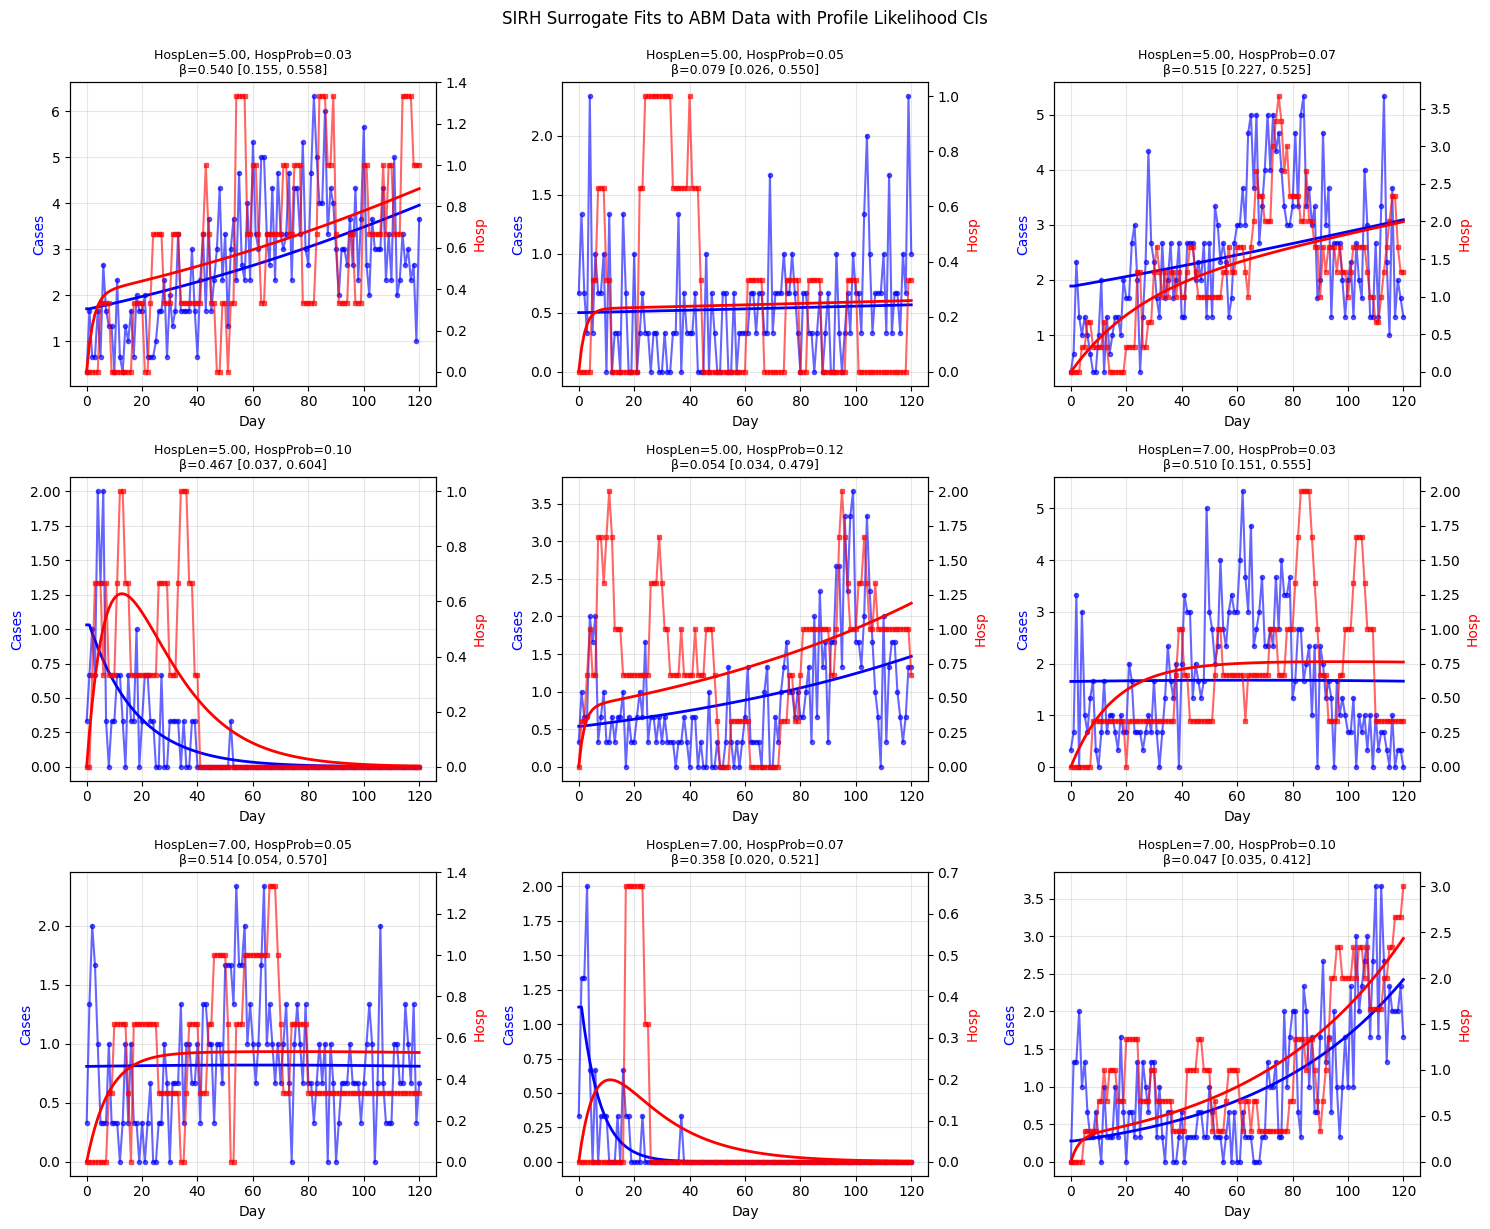

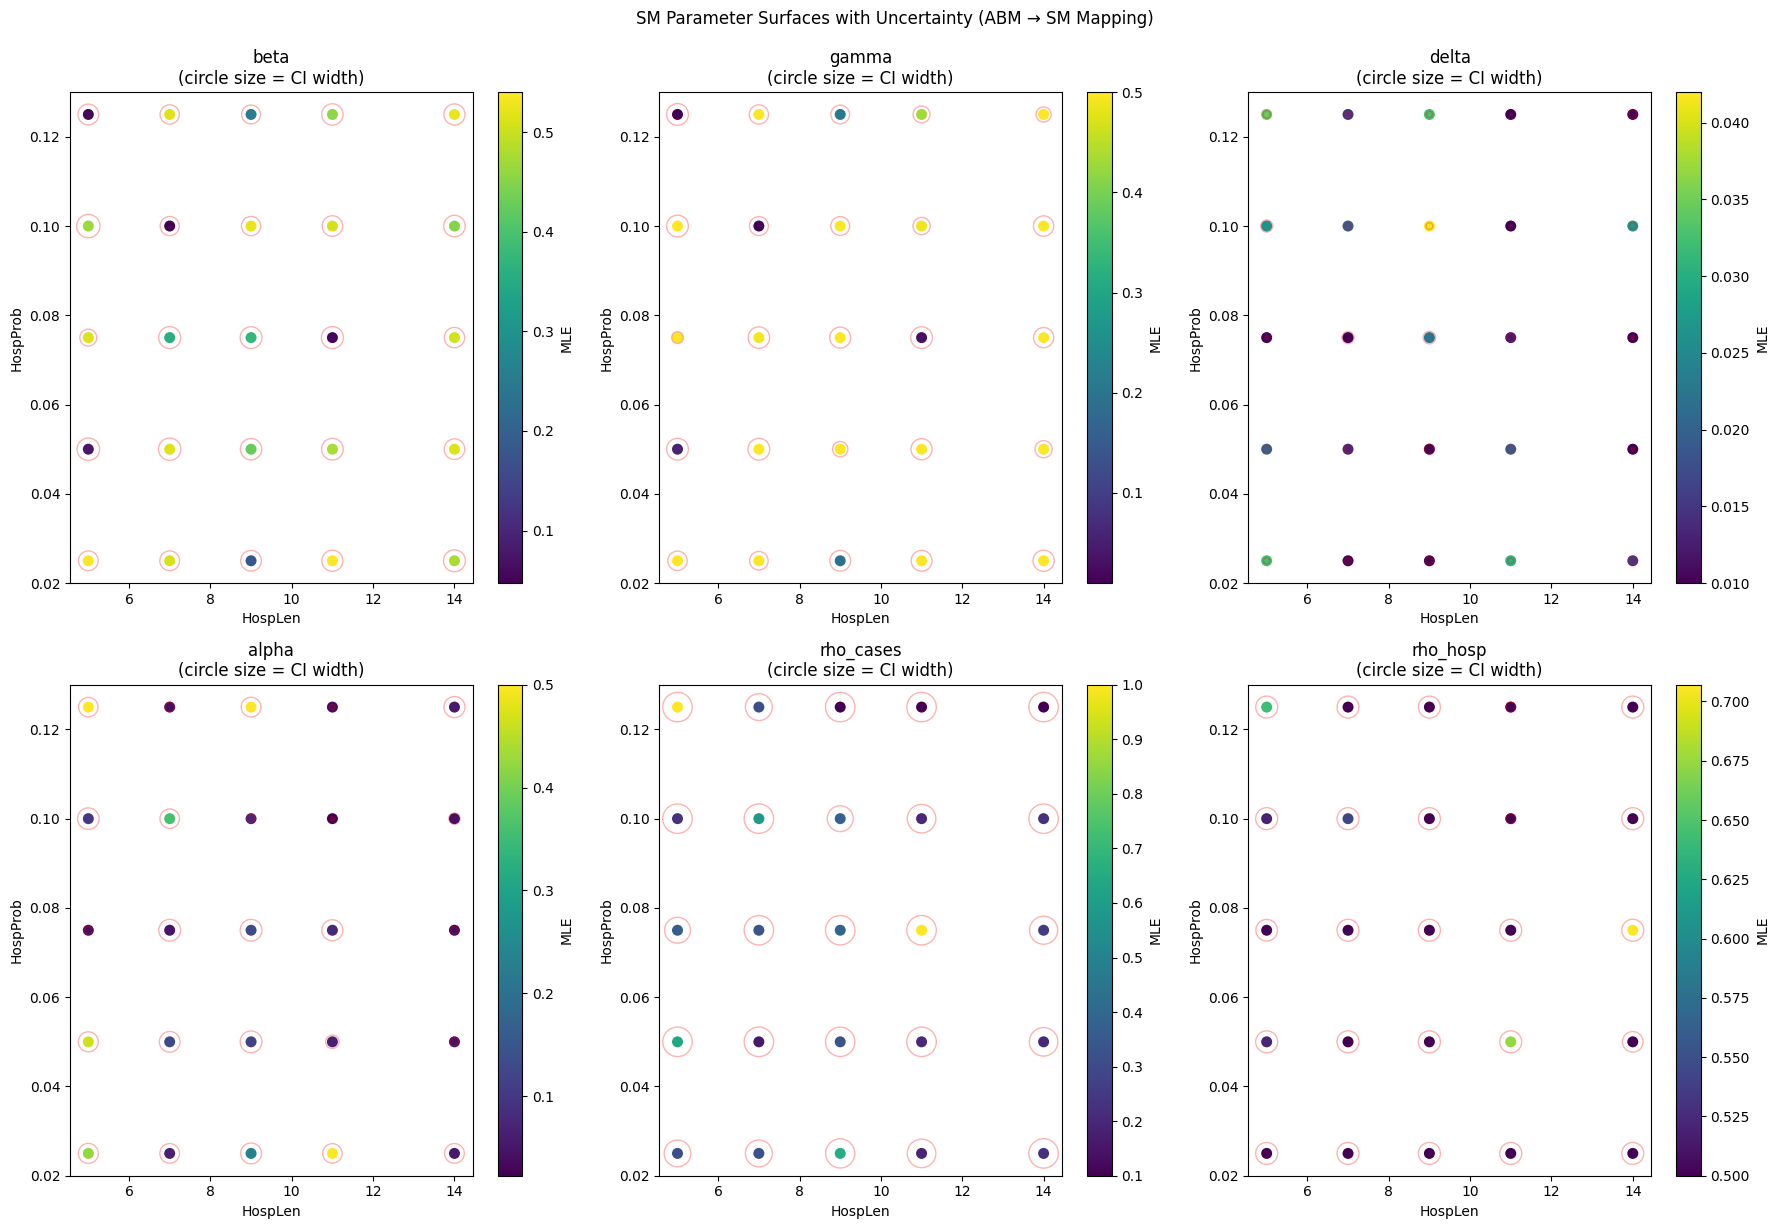


SMoRe ParS ANALYSIS SUMMARY

1. ABM FITS
   Successful fits: 25
   ABM parameters: ['HospLen', 'HospProb']

   SM Parameter Ranges (from ABM fits):
   beta: [0.0473, 0.5402] (mean: 0.3949)
   gamma: [0.0100, 0.5000] (mean: 0.3968)
   delta: [0.0100, 0.0420] (mean: 0.0185)
   alpha: [0.0226, 0.5000] (mean: 0.1658)


Fits exported to smore_pars_fits.csv


In [7]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize, minimize_scalar
from scipy.interpolate import LinearNDInterpolator, NearestNDInterpolator
from scipy.integrate import odeint
from scipy.stats import chi2
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import seaborn as sns
from typing import Dict, List, Tuple, Optional, Callable
from dataclasses import dataclass
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


# =============================================================================
# SIRH MODEL
# =============================================================================

class SIRHModel:
    """
    SIRH (Susceptible-Infected-Recovered-Hospitalized) compartmental model
    """
    
    def __init__(self, population_size: int):
        self.N = population_size
    
    def derivatives(self, y, t, params):
        """SIRH differential equations"""
        S, I, R, H = y
        beta, gamma, delta, alpha = params
        
        # Force of infection
        force = beta * S * I / self.N
        
        dS = -force
        dI = force - gamma * I - delta * I
        dR = gamma * I + alpha * H
        dH = delta * I - alpha * H
        
        return [dS, dI, dR, dH]
    
    def simulate(self, t: np.ndarray, params: List[float], 
                 initial_conditions: List[float]) -> np.ndarray:
        """Simulate the SIRH model"""
        solution = odeint(self.derivatives, initial_conditions, t, args=(params,))
        return solution
    
    def get_observables(self, solution: np.ndarray, t: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Extract observable quantities from solution"""
        S, I, R, H = solution.T
        
        # New cases: -dS/dt (approximated by differences)
        new_cases = np.zeros(len(t))
        new_cases[1:] = -np.diff(S)
        new_cases[0] = new_cases[1] if len(new_cases) > 1 else 0
        new_cases = np.maximum(new_cases, 0)
        
        # Total hospitalized
        total_hospitalized = H
        
        return new_cases, total_hospitalized


# =============================================================================
# DATA STRUCTURES
# =============================================================================

@dataclass
class ParameterEstimate:
    """Stores parameter estimate with confidence interval"""
    name: str
    mle: float
    ci_lower: float
    ci_upper: float
    
    @property
    def ci_width(self) -> float:
        return self.ci_upper - self.ci_lower


@dataclass
class SurrogateModelFit:
    """Complete fit results for one ABM parameter combination"""
    abm_params: Dict[str, float]  # e.g., {'HospLen': 5, 'HospProb': 0.1}
    sm_estimates: Dict[str, ParameterEstimate]  # Parameter estimates with CIs
    nll: float  # Negative log-likelihood at MLE
    success: bool


@dataclass 
class DataFit:
    """Fit results from fitting surrogate to real data"""
    sm_estimates: Dict[str, ParameterEstimate]
    nll: float
    success: bool


# =============================================================================
# PROFILE LIKELIHOOD
# =============================================================================

class ProfileLikelihood:
    """
    Profile likelihood computation for confidence intervals
    """
    
    def __init__(self, alpha: float = 0.05):
        """
        Args:
            alpha: Significance level (0.05 for 95% CI)
        """
        self.alpha = alpha
        self.chi2_threshold = chi2.ppf(1 - alpha, df=1)
    
    def compute_profile_ci(
        self,
        objective_func: Callable,
        mle_params: np.ndarray,
        param_index: int,
        param_bounds: Tuple[float, float],
        other_bounds: List[Tuple[float, float]],
        mle_value: float,
        n_points: int = 20
    ) -> Tuple[float, float]:
        """
        Compute profile likelihood confidence interval for one parameter
        
        Args:
            objective_func: Negative log-likelihood function
            mle_params: MLE parameter values
            param_index: Index of parameter to profile
            param_bounds: Bounds for the profiled parameter
            other_bounds: Bounds for all other parameters
            mle_value: NLL at MLE
            n_points: Number of points for profiling
            
        Returns:
            (ci_lower, ci_upper): Profile likelihood confidence interval
        """
        threshold = mle_value + 0.5 * self.chi2_threshold
        
        mle_param_value = mle_params[param_index]
        
        def profiled_objective(fixed_value):
            """Optimize over all other parameters with one fixed"""
            def reduced_objective(other_params):
                full_params = np.insert(other_params, param_index, fixed_value)
                return objective_func(full_params)
            
            # Get other parameters' initial values and bounds
            other_initial = np.delete(mle_params, param_index)
            reduced_bounds = [b for i, b in enumerate(other_bounds) if i != param_index]
            
            try:
                result = minimize(
                    reduced_objective,
                    other_initial,
                    bounds=reduced_bounds,
                    method='L-BFGS-B',
                    options={'maxiter': 500}
                )
                return result.fun
            except:
                return np.inf
        
        # Find lower CI bound
        ci_lower = self._find_ci_bound(
            profiled_objective, 
            mle_param_value, 
            param_bounds[0],
            threshold,
            direction='lower'
        )
        
        # Find upper CI bound
        ci_upper = self._find_ci_bound(
            profiled_objective,
            mle_param_value,
            param_bounds[1],
            threshold,
            direction='upper'
        )
        
        return ci_lower, ci_upper
    
    def _find_ci_bound(
        self,
        profiled_objective: Callable,
        mle_value: float,
        bound: float,
        threshold: float,
        direction: str
    ) -> float:
        """Find CI bound using bisection search"""
        
        if direction == 'lower':
            search_min, search_max = bound, mle_value
        else:
            search_min, search_max = mle_value, bound
        
        # Check if bound is within threshold
        bound_nll = profiled_objective(bound)
        if bound_nll <= threshold:
            return bound
        
        # Bisection search
        for _ in range(30):  # Max iterations
            mid = (search_min + search_max) / 2
            mid_nll = profiled_objective(mid)
            
            if abs(mid_nll - threshold) < 0.01:
                return mid
            
            if direction == 'lower':
                if mid_nll > threshold:
                    search_min = mid
                else:
                    search_max = mid
            else:
                if mid_nll > threshold:
                    search_max = mid
                else:
                    search_min = mid
        
        return mid


# =============================================================================
# SURROGATE MODEL FITTER
# =============================================================================

class SurrogateModelFitter:
    """
    Fits SIRH surrogate model to ABM output with profile likelihood CIs
    """
    
    PARAM_NAMES = ['beta', 'gamma', 'delta', 'alpha', 'rho_cases', 'rho_hosp', 'sigma_cases', 'sigma_hosp']
    
    PARAM_BOUNDS = [
        (0.01, 2.0),    # beta
        (0.01, 0.5),    # gamma
        (0.01, 0.3),    # delta
        (0.01, 0.5),    # alpha
        (0.1, 1.0),     # rho_cases
        (0.5, 1.0),     # rho_hosp
        (1.0, 200.0),   # sigma_cases
        (1.0, 100.0),   # sigma_hosp
    ]
    
    def __init__(self, population_size: int, compute_cis: bool = True):
        self.population_size = population_size
        self.sirh_model = SIRHModel(population_size)
        self.compute_cis = compute_cis
        self.profile_likelihood = ProfileLikelihood(alpha=0.05)
    
    def _create_objective(
        self,
        t: np.ndarray,
        cases_obs: np.ndarray,
        cases_std: np.ndarray,
        hosp_obs: np.ndarray,
        hosp_std: np.ndarray
    ) -> Callable:
        """Create negative log-likelihood objective function"""
        
        def objective(params):
            beta, gamma, delta, alpha, rho_cases, rho_hosp, sigma_cases, sigma_hosp = params
            
            # Parameter validity checks
            if any([
                beta <= 0, gamma <= 0, delta <= 0, alpha <= 0,
                rho_cases <= 0, rho_cases > 1,
                rho_hosp <= 0, rho_hosp > 1,
                sigma_cases <= 0, sigma_hosp <= 0
            ]):
                return np.inf
            
            try:
                # Initial conditions
                I0 = 10
                S0 = self.population_size - I0
                initial_conditions = [S0, I0, 0, 0]
                
                # Simulate
                sol = self.sirh_model.simulate(t, [beta, gamma, delta, alpha], initial_conditions)
                new_cases_true, total_hosp_true = self.sirh_model.get_observables(sol, t)
                
                # Apply reporting rates
                new_cases_expected = rho_cases * new_cases_true
                total_hosp_expected = rho_hosp * total_hosp_true
                
                # Match lengths
                min_len = min(len(cases_obs), len(new_cases_expected))
                data_cases = cases_obs[:min_len]
                pred_cases = new_cases_expected[:min_len]
                
                min_len_hosp = min(len(hosp_obs), len(total_hosp_expected))
                data_hosp = hosp_obs[:min_len_hosp]
                pred_hosp = total_hosp_expected[:min_len_hosp]
                
                # Gaussian log-likelihood
                ll_cases = -0.5 * np.sum(((data_cases - pred_cases) / sigma_cases) ** 2)
                ll_cases -= len(data_cases) * np.log(sigma_cases * np.sqrt(2 * np.pi))
                
                ll_hosp = -0.5 * np.sum(((data_hosp - pred_hosp) / sigma_hosp) ** 2)
                ll_hosp -= len(data_hosp) * np.log(sigma_hosp * np.sqrt(2 * np.pi))
                
                total_ll = ll_cases + ll_hosp
                
                if np.isnan(total_ll) or np.isinf(total_ll):
                    return np.inf
                
                return -total_ll
                
            except Exception:
                return np.inf
        
        return objective
    
    def _get_initial_params(self) -> np.ndarray:
        """Generate random initial parameters"""
        return np.array([
            np.random.uniform(0.1, 1.0),    # beta
            np.random.uniform(0.05, 0.3),   # gamma
            np.random.uniform(0.02, 0.15),  # delta
            np.random.uniform(0.05, 0.2),   # alpha
            np.random.uniform(0.2, 0.8),    # rho_cases
            np.random.uniform(0.6, 0.95),   # rho_hosp
            np.random.uniform(10, 100),     # sigma_cases
            np.random.uniform(5, 50)        # sigma_hosp
        ])
    
    def fit(
        self,
        t: np.ndarray,
        cases_obs: np.ndarray,
        cases_std: np.ndarray,
        hosp_obs: np.ndarray,
        hosp_std: np.ndarray,
        abm_params: Dict[str, float],
        n_attempts: int = 10
    ) -> Optional[SurrogateModelFit]:
        """
        Fit SIRH model with profile likelihood confidence intervals
        """
        objective = self._create_objective(t, cases_obs, cases_std, hosp_obs, hosp_std)
        
        # Multi-start optimization for MLE
        best_result = None
        best_nll = np.inf
        
        for _ in range(n_attempts):
            try:
                result = minimize(
                    objective,
                    self._get_initial_params(),
                    bounds=self.PARAM_BOUNDS,
                    method='L-BFGS-B',
                    options={'maxiter': 2000}
                )
                
                if result.fun < best_nll:
                    best_nll = result.fun
                    best_result = result
                    
            except Exception:
                continue
        
        if best_result is None or not np.isfinite(best_nll):
            return None
        
        mle_params = best_result.x
        
        # Compute profile likelihood CIs for each parameter
        sm_estimates = {}
        
        for i, param_name in enumerate(self.PARAM_NAMES):
            mle_value = mle_params[i]
            
            if self.compute_cis:
                try:
                    ci_lower, ci_upper = self.profile_likelihood.compute_profile_ci(
                        objective_func=objective,
                        mle_params=mle_params,
                        param_index=i,
                        param_bounds=self.PARAM_BOUNDS[i],
                        other_bounds=self.PARAM_BOUNDS,
                        mle_value=best_nll,
                        n_points=15
                    )
                except Exception:
                    # Fallback: use parameter bounds as CI
                    ci_lower, ci_upper = self.PARAM_BOUNDS[i]
            else:
                ci_lower, ci_upper = self.PARAM_BOUNDS[i]
            
            sm_estimates[param_name] = ParameterEstimate(
                name=param_name,
                mle=mle_value,
                ci_lower=ci_lower,
                ci_upper=ci_upper
            )
        
        return SurrogateModelFit(
            abm_params=abm_params,
            sm_estimates=sm_estimates,
            nll=best_nll,
            success=True
        )


# =============================================================================
# PARAMETER SURFACE RECONSTRUCTOR
# =============================================================================

class ParameterSurfaceReconstructor:
    """
    Reconstructs continuous response surfaces from discrete ABM-SM mappings
    using LinearNDInterpolator
    """
    
    def __init__(self, abm_param_names: List[str], sm_param_names: List[str]):
        self.abm_param_names = abm_param_names
        self.sm_param_names = sm_param_names
        
        # Interpolators for MLE and CI bounds
        self.mle_interpolators: Dict[str, LinearNDInterpolator] = {}
        self.ci_lower_interpolators: Dict[str, LinearNDInterpolator] = {}
        self.ci_upper_interpolators: Dict[str, LinearNDInterpolator] = {}
        
        # Fallback nearest-neighbor interpolators for extrapolation
        self.mle_nearest: Dict[str, NearestNDInterpolator] = {}
        self.ci_lower_nearest: Dict[str, NearestNDInterpolator] = {}
        self.ci_upper_nearest: Dict[str, NearestNDInterpolator] = {}
    
    def fit(self, fits: List[SurrogateModelFit]):
        """
        Build interpolated surfaces from discrete ABM-SM mappings
        """
        # Extract ABM parameter points
        abm_points = np.array([
            [fit.abm_params[name] for name in self.abm_param_names]
            for fit in fits
        ])
        
        # Build interpolators for each SM parameter
        for sm_param in self.sm_param_names:
            mle_values = np.array([fit.sm_estimates[sm_param].mle for fit in fits])
            ci_lower_values = np.array([fit.sm_estimates[sm_param].ci_lower for fit in fits])
            ci_upper_values = np.array([fit.sm_estimates[sm_param].ci_upper for fit in fits])
            
            # Linear interpolators
            self.mle_interpolators[sm_param] = LinearNDInterpolator(abm_points, mle_values)
            self.ci_lower_interpolators[sm_param] = LinearNDInterpolator(abm_points, ci_lower_values)
            self.ci_upper_interpolators[sm_param] = LinearNDInterpolator(abm_points, ci_upper_values)
            
            # Nearest-neighbor fallbacks for extrapolation
            self.mle_nearest[sm_param] = NearestNDInterpolator(abm_points, mle_values)
            self.ci_lower_nearest[sm_param] = NearestNDInterpolator(abm_points, ci_lower_values)
            self.ci_upper_nearest[sm_param] = NearestNDInterpolator(abm_points, ci_upper_values)
    
    def predict(self, abm_params: Dict[str, float]) -> Dict[str, ParameterEstimate]:
        """
        Predict SM parameters (with CIs) for given ABM parameters
        """
        point = np.array([[abm_params[name] for name in self.abm_param_names]])
        
        predictions = {}
        for sm_param in self.sm_param_names:
            mle = self.mle_interpolators[sm_param](point)[0]
            ci_lower = self.ci_lower_interpolators[sm_param](point)[0]
            ci_upper = self.ci_upper_interpolators[sm_param](point)[0]
            
            # Use nearest-neighbor if linear interpolation returns NaN (extrapolation)
            if np.isnan(mle):
                mle = self.mle_nearest[sm_param](point)[0]
            if np.isnan(ci_lower):
                ci_lower = self.ci_lower_nearest[sm_param](point)[0]
            if np.isnan(ci_upper):
                ci_upper = self.ci_upper_nearest[sm_param](point)[0]
            
            predictions[sm_param] = ParameterEstimate(
                name=sm_param,
                mle=mle,
                ci_lower=ci_lower,
                ci_upper=ci_upper
            )
        
        return predictions
    
    def predict_batch(self, abm_params_list: List[Dict[str, float]]) -> List[Dict[str, ParameterEstimate]]:
        """Predict SM parameters for multiple ABM parameter combinations"""
        return [self.predict(params) for params in abm_params_list]


# =============================================================================
# ABM PARAMETER SPACE FILTER
# =============================================================================

class ABMParameterSpaceFilter:
    """
    Filters ABM parameter space to retain only combinations consistent with data
    """
    
    def __init__(
        self,
        surface_reconstructor: ParameterSurfaceReconstructor,
        data_fit: DataFit,
        params_to_check: Optional[List[str]] = None
    ):
        self.surface = surface_reconstructor
        self.data_fit = data_fit
        self.params_to_check = params_to_check or ['beta', 'gamma', 'delta', 'alpha']
    
    def is_consistent(self, abm_params: Dict[str, float]) -> bool:
        """
        Check if ABM parameters are consistent with data-derived CIs
        
        An ABM parameter combination is consistent if its projected SM parameters
        fall within the data-derived 95% confidence intervals
        """
        # Get SM parameters predicted from ABM parameters
        sm_predictions = self.surface.predict(abm_params)
        
        # Check each parameter
        for param_name in self.params_to_check:
            if param_name not in sm_predictions or param_name not in self.data_fit.sm_estimates:
                continue
            
            predicted = sm_predictions[param_name]
            data_ci = self.data_fit.sm_estimates[param_name]
            
            # Check if predicted value (or its CI) overlaps with data CI
            # Using overlap criterion: intervals overlap if max(lower) < min(upper)
            overlap = (
                max(predicted.ci_lower, data_ci.ci_lower) < 
                min(predicted.ci_upper, data_ci.ci_upper)
            )
            
            if not overlap:
                return False
        
        return True
    
    def filter(self, abm_params_list: List[Dict[str, float]]) -> List[Dict[str, float]]:
        """Filter ABM parameter list to retain only data-consistent combinations"""
        return [params for params in abm_params_list if self.is_consistent(params)]
    
    def get_consistency_scores(
        self, 
        abm_params_list: List[Dict[str, float]]
    ) -> List[Tuple[Dict[str, float], float]]:
        """
        Compute consistency score for each ABM parameter combination
        Score = number of SM parameters with overlapping CIs / total checked
        """
        results = []
        
        for abm_params in abm_params_list:
            sm_predictions = self.surface.predict(abm_params)
            
            n_consistent = 0
            n_checked = 0
            
            for param_name in self.params_to_check:
                if param_name not in sm_predictions or param_name not in self.data_fit.sm_estimates:
                    continue
                
                n_checked += 1
                predicted = sm_predictions[param_name]
                data_ci = self.data_fit.sm_estimates[param_name]
                
                overlap = (
                    max(predicted.ci_lower, data_ci.ci_lower) < 
                    min(predicted.ci_upper, data_ci.ci_upper)
                )
                
                if overlap:
                    n_consistent += 1
            
            score = n_consistent / n_checked if n_checked > 0 else 0
            results.append((abm_params, score))
        
        return results


# =============================================================================
# MAIN SMoRe ParS CLASS
# =============================================================================

class SMoReParS:
    """
    Complete SMoRe ParS implementation for bridging ABM and mechanistic models
    """
    
    SM_PARAM_NAMES = ['beta', 'gamma', 'delta', 'alpha', 'rho_cases', 'rho_hosp', 'sigma_cases', 'sigma_hosp']
    
    def __init__(
        self,
        population_size: int,
        abm_param_names: List[str] = ['HospLen', 'HospProb'],
        compute_profile_cis: bool = True
    ):
        self.population_size = population_size
        self.abm_param_names = abm_param_names
        self.compute_profile_cis = compute_profile_cis
        
        self.sirh_model = SIRHModel(population_size)
        self.fitter = SurrogateModelFitter(population_size, compute_cis=compute_profile_cis)
        
        self.fred_data: Optional[pd.DataFrame] = None
        self.aggregated_data: Optional[pd.DataFrame] = None
        self.fits: List[SurrogateModelFit] = []
        self.surface: Optional[ParameterSurfaceReconstructor] = None
        self.data_fit: Optional[DataFit] = None
        self.filter: Optional[ABMParameterSpaceFilter] = None
    
    # -------------------------------------------------------------------------
    # Data Loading
    # -------------------------------------------------------------------------
    
    def load_fred_data(self, filepath: str) -> pd.DataFrame:
        """Load and preprocess FRED ABM simulation data"""
        print("Loading FRED ABM data...")
        self.fred_data = pd.read_csv(filepath)
        
        print(f"Available columns: {self.fred_data.columns.tolist()}")
        
        # Map to standard column names
        if 'INF.newIs' in self.fred_data.columns:
            self.fred_data['new_infections'] = self.fred_data['INF.newIs']
        elif 'new_infections' not in self.fred_data.columns:
            raise ValueError("Could not find new infections column")
        
        if 'INF.H' in self.fred_data.columns:
            self.fred_data['total_hospitalized'] = self.fred_data['INF.H']
        elif 'total_hospitalized' not in self.fred_data.columns:
            raise ValueError("Could not find hospitalizations column")
        
        n_combinations = self.fred_data.groupby(self.abm_param_names).ngroups
        print(f"Loaded {len(self.fred_data)} rows")
        print(f"ABM parameter combinations: {n_combinations}")
        print(f"Replicates per combination: {self.fred_data['replicate'].nunique()}")
        
        return self.fred_data
    
    def aggregate_fred_runs(self) -> pd.DataFrame:
        """Aggregate FRED runs by parameter combination and day"""
        print("Aggregating FRED runs...")
        
        group_cols = self.abm_param_names + ['Day']
        
        aggregated = self.fred_data.groupby(group_cols).agg({
            'new_infections': ['mean', 'std'],
            'total_hospitalized': ['mean', 'std']
        }).reset_index()
        
        # Flatten column names
        aggregated.columns = (
            self.abm_param_names + ['Day'] +
            ['new_infections_mean', 'new_infections_std',
             'total_hospitalized_mean', 'total_hospitalized_std']
        )
        
        # Fill NaN std and ensure minimum
        for col in ['new_infections_std', 'total_hospitalized_std']:
            aggregated[col] = aggregated[col].fillna(1.0)
            aggregated[col] = np.maximum(aggregated[col], 1.0)
        
        self.aggregated_data = aggregated
        print(f"Aggregated to {len(aggregated)} parameter-day combinations")
        
        return aggregated
    
    # -------------------------------------------------------------------------
    # Step 1: Fit Surrogate Models to ABM Output
    # -------------------------------------------------------------------------
    
    def fit_all_abm_runs(self, n_attempts: int = 10) -> List[SurrogateModelFit]:
        """
        Fit SIRH surrogate model to each ABM parameter combination
        with profile likelihood confidence intervals
        """
        print(f"Fitting SIRH surrogate models with profile likelihood CIs...")
        print(f"(Profile CIs: {self.compute_profile_cis})")
        
        if self.aggregated_data is None:
            self.aggregate_fred_runs()
        
        # Get unique ABM parameter combinations
        param_combinations = self.aggregated_data[self.abm_param_names].drop_duplicates()
        
        self.fits = []
        
        for _, row in tqdm(param_combinations.iterrows(), total=len(param_combinations)):
            abm_params = {name: row[name] for name in self.abm_param_names}
            
            # Get data for this combination
            mask = True
            for name in self.abm_param_names:
                mask = mask & (self.aggregated_data[name] == abm_params[name])
            
            run_data = self.aggregated_data[mask].sort_values('Day')
            
            if len(run_data) == 0:
                continue
            
            t = run_data['Day'].values
            cases_obs = run_data['new_infections_mean'].values
            cases_std = run_data['new_infections_std'].values
            hosp_obs = run_data['total_hospitalized_mean'].values
            hosp_std = run_data['total_hospitalized_std'].values
            
            # Fit with profile likelihood CIs
            fit = self.fitter.fit(
                t, cases_obs, cases_std, hosp_obs, hosp_std,
                abm_params, n_attempts=n_attempts
            )
            
            if fit is not None:
                self.fits.append(fit)
        
        print(f"Successfully fit {len(self.fits)}/{len(param_combinations)} combinations")
        
        return self.fits
    
    # -------------------------------------------------------------------------
    # Step 2: Reconstruct Parameter Surfaces
    # -------------------------------------------------------------------------
    
    def reconstruct_surfaces(self) -> ParameterSurfaceReconstructor:
        """
        Reconstruct continuous response surfaces via LinearNDInterpolator
        """
        print("Reconstructing parameter surfaces with LinearNDInterpolator...")
        
        if len(self.fits) == 0:
            raise ValueError("No fits available. Run fit_all_abm_runs() first.")
        
        self.surface = ParameterSurfaceReconstructor(
            abm_param_names=self.abm_param_names,
            sm_param_names=self.SM_PARAM_NAMES
        )
        
        self.surface.fit(self.fits)
        
        print(f"Built interpolated surfaces for {len(self.SM_PARAM_NAMES)} SM parameters")
        print("Surfaces include: MLE values, CI lower bounds, CI upper bounds")
        
        return self.surface
    
    # -------------------------------------------------------------------------
    # Step 3: Fit Surrogate to Real Data
    # -------------------------------------------------------------------------
    
    def fit_to_data(
        self,
        t: np.ndarray,
        cases_data: np.ndarray,
        hosp_data: np.ndarray,
        cases_std: Optional[np.ndarray] = None,
        hosp_std: Optional[np.ndarray] = None,
        n_attempts: int = 15
    ) -> DataFit:
        """
        Fit SIRH surrogate directly to observed data with profile likelihood CIs
        """
        print("Fitting SIRH model to observed data with profile likelihood CIs...")
        
        if cases_std is None:
            cases_std = np.ones_like(cases_data) * np.std(cases_data) * 0.1
        if hosp_std is None:
            hosp_std = np.ones_like(hosp_data) * np.std(hosp_data) * 0.1
        
        # Create fitter with CIs enabled
        data_fitter = SurrogateModelFitter(self.population_size, compute_cis=True)
        
        fit = data_fitter.fit(
            t, cases_data, cases_std, hosp_data, hosp_std,
            abm_params={},  # No ABM params for data fit
            n_attempts=n_attempts
        )
        
        if fit is None:
            raise ValueError("Failed to fit model to observed data")
        
        self.data_fit = DataFit(
            sm_estimates=fit.sm_estimates,
            nll=fit.nll,
            success=fit.success
        )
        
        print("Data fit complete. Parameter estimates with 95% CIs:")
        for name, est in self.data_fit.sm_estimates.items():
            print(f"  {name}: {est.mle:.4f} [{est.ci_lower:.4f}, {est.ci_upper:.4f}]")
        
        return self.data_fit
    
    # -------------------------------------------------------------------------
    # Step 4: Filter ABM Parameter Space
    # -------------------------------------------------------------------------
    
    def filter_abm_space(
        self,
        params_to_check: Optional[List[str]] = None
    ) -> List[Dict[str, float]]:
        """
        Filter ABM parameter space to retain data-consistent combinations
        """
        print("Filtering ABM parameter space for data consistency...")
        
        if self.surface is None:
            raise ValueError("Surfaces not reconstructed. Run reconstruct_surfaces() first.")
        if self.data_fit is None:
            raise ValueError("No data fit available. Run fit_to_data() first.")
        
        self.filter = ABMParameterSpaceFilter(
            surface_reconstructor=self.surface,
            data_fit=self.data_fit,
            params_to_check=params_to_check or ['beta', 'gamma', 'delta', 'alpha']
        )
        
        # Get all ABM parameter combinations
        all_abm_params = [fit.abm_params for fit in self.fits]
        
        # Filter
        consistent_params = self.filter.filter(all_abm_params)
        
        print(f"Retained {len(consistent_params)}/{len(all_abm_params)} ABM parameter combinations")
        
        return consistent_params
    
    def get_consistency_scores(self) -> pd.DataFrame:
        """Get consistency scores for all ABM parameter combinations"""
        if self.filter is None:
            raise ValueError("Filter not created. Run filter_abm_space() first.")
        
        all_abm_params = [fit.abm_params for fit in self.fits]
        scores = self.filter.get_consistency_scores(all_abm_params)
        
        # Convert to DataFrame
        records = []
        for params, score in scores:
            record = params.copy()
            record['consistency_score'] = score
            records.append(record)
        
        return pd.DataFrame(records)
    
    # -------------------------------------------------------------------------
    # Visualization
    # -------------------------------------------------------------------------
    
    def plot_fits_with_cis(self, max_plots: int = 9, figsize: Tuple[int, int] = (15, 12)):
        """Plot SIRH fits to ABM data showing confidence intervals"""
        
        n_plots = min(max_plots, len(self.fits))
        n_cols = 3
        n_rows = int(np.ceil(n_plots / n_cols))
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
        axes = axes.flatten()
        
        for i, fit in enumerate(self.fits[:n_plots]):
            ax = axes[i]
            
            # Get ABM data
            mask = True
            for name in self.abm_param_names:
                mask = mask & (self.aggregated_data[name] == fit.abm_params[name])
            
            run_data = self.aggregated_data[mask].sort_values('Day')
            t = run_data['Day'].values
            cases_obs = run_data['new_infections_mean'].values
            hosp_obs = run_data['total_hospitalized_mean'].values
            
            # Generate predictions
            beta = fit.sm_estimates['beta'].mle
            gamma = fit.sm_estimates['gamma'].mle
            delta = fit.sm_estimates['delta'].mle
            alpha = fit.sm_estimates['alpha'].mle
            rho_cases = fit.sm_estimates['rho_cases'].mle
            rho_hosp = fit.sm_estimates['rho_hosp'].mle
            
            I0 = 10
            S0 = self.population_size - I0
            sol = self.sirh_model.simulate(t, [beta, gamma, delta, alpha], [S0, I0, 0, 0])
            cases_true, hosp_true = self.sirh_model.get_observables(sol, t)
            
            cases_pred = rho_cases * cases_true
            hosp_pred = rho_hosp * hosp_true
            
            # Plot
            ax.plot(t, cases_obs, 'bo-', alpha=0.6, label='ABM Cases', markersize=3)
            ax.plot(t, cases_pred[:len(t)], 'b-', linewidth=2, label='SIRH Fit')
            
            ax2 = ax.twinx()
            ax2.plot(t, hosp_obs, 'rs-', alpha=0.6, label='ABM Hosp', markersize=3)
            ax2.plot(t, hosp_pred[:len(t)], 'r-', linewidth=2, label='SIRH Fit')
            
            # Title with key parameters and CIs
            title_parts = [f"{k}={v:.2f}" for k, v in fit.abm_params.items()]
            title = ', '.join(title_parts)
            title += f"\nβ={beta:.3f} [{fit.sm_estimates['beta'].ci_lower:.3f}, {fit.sm_estimates['beta'].ci_upper:.3f}]"
            ax.set_title(title, fontsize=9)
            ax.set_xlabel('Day')
            ax.set_ylabel('Cases', color='blue')
            ax2.set_ylabel('Hosp', color='red')
            ax.grid(True, alpha=0.3)
        
        for j in range(i + 1, len(axes)):
            axes[j].set_visible(False)
        
        plt.tight_layout()
        plt.suptitle('SIRH Surrogate Fits to ABM Data with Profile Likelihood CIs', y=1.02)
        plt.show()
    
    def plot_parameter_surfaces(self, figsize: Tuple[int, int] = (18, 12)):
        """Plot parameter surfaces with uncertainty bands"""
        
        if self.surface is None or len(self.fits) == 0:
            print("No surfaces to plot")
            return
        
        params_to_plot = ['beta', 'gamma', 'delta', 'alpha', 'rho_cases', 'rho_hosp']
        n_params = len(params_to_plot)
        n_cols = 3
        n_rows = int(np.ceil(n_params / n_cols))
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
        axes = axes.flatten()
        
        # Get ABM parameter ranges
        abm_ranges = {}
        for name in self.abm_param_names:
            values = [fit.abm_params[name] for fit in self.fits]
            abm_ranges[name] = (min(values), max(values))
        
        # Create meshgrid
        n_grid = 30
        grids = [np.linspace(abm_ranges[name][0], abm_ranges[name][1], n_grid) 
                 for name in self.abm_param_names]
        mesh = np.meshgrid(*grids)
        
        for i, param_name in enumerate(params_to_plot):
            ax = axes[i]
            
            # Get actual fit values
            abm_x = [fit.abm_params[self.abm_param_names[0]] for fit in self.fits]
            abm_y = [fit.abm_params[self.abm_param_names[1]] for fit in self.fits]
            mle_values = [fit.sm_estimates[param_name].mle for fit in self.fits]
            ci_widths = [fit.sm_estimates[param_name].ci_width for fit in self.fits]
            
            # Plot MLE surface
            scatter = ax.scatter(abm_x, abm_y, c=mle_values, cmap='viridis', 
                               s=80, edgecolors='white', linewidth=1)
            
            # Add CI width as size
            ax.scatter(abm_x, abm_y, c='none', edgecolors='red', 
                      s=[w * 500 for w in ci_widths], alpha=0.3, linewidth=1)
            
            ax.set_xlabel(self.abm_param_names[0])
            ax.set_ylabel(self.abm_param_names[1])
            ax.set_title(f'{param_name}\n(circle size = CI width)')
            
            cbar = plt.colorbar(scatter, ax=ax)
            cbar.set_label('MLE')
        
        for j in range(i + 1, len(axes)):
            axes[j].set_visible(False)
        
        plt.tight_layout()
        plt.suptitle('SM Parameter Surfaces with Uncertainty (ABM → SM Mapping)', y=1.02)
        plt.show()
    
    def plot_data_consistency(self, figsize: Tuple[int, int] = (12, 8)):
        """Plot ABM parameter space colored by consistency with data"""
        
        if self.filter is None:
            print("Run filter_abm_space() first")
            return
        
        scores_df = self.get_consistency_scores()
        
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        
        # Plot 1: Consistency score heatmap
        ax1 = axes[0]
        scatter = ax1.scatter(
            scores_df[self.abm_param_names[0]],
            scores_df[self.abm_param_names[1]],
            c=scores_df['consistency_score'],
            cmap='RdYlGn',
            s=100,
            edgecolors='black',
            linewidth=0.5
        )
        ax1.set_xlabel(self.abm_param_names[0])
        ax1.set_ylabel(self.abm_param_names[1])
        ax1.set_title('ABM Parameter Consistency with Data\n(green = consistent, red = inconsistent)')
        plt.colorbar(scatter, ax=ax1, label='Consistency Score')
        
        # Plot 2: Binary consistent/inconsistent
        ax2 = axes[1]
        consistent = scores_df[scores_df['consistency_score'] == 1.0]
        inconsistent = scores_df[scores_df['consistency_score'] < 1.0]
        
        ax2.scatter(
            inconsistent[self.abm_param_names[0]],
            inconsistent[self.abm_param_names[1]],
            c='red', s=80, alpha=0.5, label='Inconsistent', marker='x'
        )
        ax2.scatter(
            consistent[self.abm_param_names[0]],
            consistent[self.abm_param_names[1]],
            c='green', s=80, alpha=0.7, label='Consistent', marker='o'
        )
        ax2.set_xlabel(self.abm_param_names[0])
        ax2.set_ylabel(self.abm_param_names[1])
        ax2.set_title('Data-Consistent ABM Parameter Region')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Print summary
        n_consistent = len(consistent)
        n_total = len(scores_df)
        print(f"\nConsistency Summary:")
        print(f"  Total ABM combinations: {n_total}")
        print(f"  Consistent with data: {n_consistent} ({100*n_consistent/n_total:.1f}%)")
        
        if n_consistent > 0:
            print(f"\nData-consistent ABM parameter ranges:")
            for name in self.abm_param_names:
                vals = consistent[name]
                print(f"  {name}: [{vals.min():.3f}, {vals.max():.3f}]")
    
    def plot_ci_comparison(self, figsize: Tuple[int, int] = (14, 10)):
        """Compare ABM-derived CIs with data-derived CIs"""
        
        if self.data_fit is None or len(self.fits) == 0:
            print("Need both ABM fits and data fit")
            return
        
        params_to_plot = ['beta', 'gamma', 'delta', 'alpha']
        
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        axes = axes.flatten()
        
        for i, param_name in enumerate(params_to_plot):
            ax = axes[i]
            
            # Get all ABM-derived estimates
            abm_mles = [fit.sm_estimates[param_name].mle for fit in self.fits]
            abm_lowers = [fit.sm_estimates[param_name].ci_lower for fit in self.fits]
            abm_uppers = [fit.sm_estimates[param_name].ci_upper for fit in self.fits]
            
            # Data-derived estimate
            data_est = self.data_fit.sm_estimates[param_name]
            
            # Plot ABM estimates with CIs
            x = range(len(self.fits))
            ax.errorbar(x, abm_mles, 
                       yerr=[np.array(abm_mles) - np.array(abm_lowers),
                             np.array(abm_uppers) - np.array(abm_mles)],
                       fmt='o', color='blue', alpha=0.5, capsize=2, 
                       label='ABM-derived', markersize=4)
            
            # Plot data-derived CI as horizontal band
            ax.axhline(data_est.mle, color='red', linewidth=2, label='Data MLE')
            ax.axhspan(data_est.ci_lower, data_est.ci_upper, 
                      color='red', alpha=0.2, label='Data 95% CI')
            
            ax.set_xlabel('ABM Parameter Combination Index')
            ax.set_ylabel(param_name)
            ax.set_title(f'{param_name}: ABM vs Data Estimates')
            ax.legend(loc='upper right')
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.suptitle('Comparison: ABM-Derived vs Data-Derived Parameter Estimates', y=1.02)
        plt.show()
    
    # -------------------------------------------------------------------------
    # Summary and Export
    # -------------------------------------------------------------------------
    
    def get_fits_dataframe(self) -> pd.DataFrame:
        """Export all fits to DataFrame with CIs"""
        records = []
        
        for fit in self.fits:
            record = fit.abm_params.copy()
            record['nll'] = fit.nll
            
            for param_name, est in fit.sm_estimates.items():
                record[f'{param_name}_mle'] = est.mle
                record[f'{param_name}_ci_lower'] = est.ci_lower
                record[f'{param_name}_ci_upper'] = est.ci_upper
                record[f'{param_name}_ci_width'] = est.ci_width
            
            records.append(record)
        
        return pd.DataFrame(records)
    
    def print_summary(self):
        """Print comprehensive summary of SMoRe ParS analysis"""
        print("\n" + "=" * 70)
        print("SMoRe ParS ANALYSIS SUMMARY")
        print("=" * 70)
        
        print(f"\n1. ABM FITS")
        print(f"   Successful fits: {len(self.fits)}")
        print(f"   ABM parameters: {self.abm_param_names}")
        
        if len(self.fits) > 0:
            print(f"\n   SM Parameter Ranges (from ABM fits):")
            for param_name in ['beta', 'gamma', 'delta', 'alpha']:
                mles = [f.sm_estimates[param_name].mle for f in self.fits]
                print(f"   {param_name}: [{min(mles):.4f}, {max(mles):.4f}] (mean: {np.mean(mles):.4f})")
        
        if self.data_fit is not None:
            print(f"\n2. DATA FIT")
            print(f"   Negative log-likelihood: {self.data_fit.nll:.2f}")
            print(f"\n   Parameter Estimates with 95% Profile Likelihood CIs:")
            for param_name in ['beta', 'gamma', 'delta', 'alpha', 'rho_cases', 'rho_hosp']:
                est = self.data_fit.sm_estimates[param_name]
                print(f"   {param_name}: {est.mle:.4f} [{est.ci_lower:.4f}, {est.ci_upper:.4f}]")
        
        if self.filter is not None:
            scores_df = self.get_consistency_scores()
            consistent = scores_df[scores_df['consistency_score'] == 1.0]
            
            print(f"\n3. ABM PARAMETER SPACE FILTERING")
            print(f"   Total combinations: {len(scores_df)}")
            print(f"   Data-consistent: {len(consistent)} ({100*len(consistent)/len(scores_df):.1f}%)")
            
            if len(consistent) > 0:
                print(f"\n   Data-consistent ABM parameter ranges:")
                for name in self.abm_param_names:
                    vals = consistent[name]
                    print(f"   {name}: [{vals.min():.3f}, {vals.max():.3f}]")
        
        print("\n" + "=" * 70)


# =============================================================================
# WORKFLOW FUNCTIONS
# =============================================================================

def run_complete_smore_pars_workflow(
    fred_data_path: str,
    experimental_cases: np.ndarray,
    experimental_hosp: np.ndarray,
    experimental_t: np.ndarray,
    population_size: int = 367600,
    compute_profile_cis: bool = True
) -> SMoReParS:
    """
    Run complete SMoRe ParS workflow
    
    Args:
        fred_data_path: Path to FRED ABM output CSV
        experimental_cases: Observed case counts
        experimental_hosp: Observed hospitalizations
        experimental_t: Time points for observations
        population_size: Population size
        compute_profile_cis: Whether to compute profile likelihood CIs
        
    Returns:
        Configured SMoReParS object with all analyses complete
    """
    print("=" * 70)
    print("SMoRe ParS: COMPLETE WORKFLOW")
    print("=" * 70)
    
    # Initialize
    smore = SMoReParS(
        population_size=population_size,
        compute_profile_cis=compute_profile_cis
    )
    
    # Step 1: Load and process ABM data
    print("\n" + "-" * 50)
    print("STEP 1: Load ABM Data")
    print("-" * 50)
    smore.load_fred_data(fred_data_path)
    smore.aggregate_fred_runs()
    
    # Step 2: Fit surrogate models to all ABM runs
    print("\n" + "-" * 50)
    print("STEP 2: Fit Surrogate Models to ABM Output")
    print("-" * 50)
    smore.fit_all_abm_runs(n_attempts=10)
    
    # Step 3: Reconstruct parameter surfaces
    print("\n" + "-" * 50)
    print("STEP 3: Reconstruct Parameter Surfaces")
    print("-" * 50)
    smore.reconstruct_surfaces()
    
    # Step 4: Fit surrogate to experimental data
    print("\n" + "-" * 50)
    print("STEP 4: Fit Surrogate to Experimental Data")
    print("-" * 50)
    smore.fit_to_data(experimental_t, experimental_cases, experimental_hosp)
    
    # Step 5: Filter ABM parameter space
    print("\n" + "-" * 50)
    print("STEP 5: Filter ABM Parameter Space")
    print("-" * 50)
    consistent_params = smore.filter_abm_space()
    
    # Summary
    smore.print_summary()
    
    return smore


def run_workflow_abm_only(
    fred_data_path: str,
    population_size: int = 367600,
    compute_profile_cis: bool = True
) -> SMoReParS:
    """
    Run SMoRe ParS workflow for ABM fitting only (no experimental data)
    """
    print("=" * 70)
    print("SMoRe ParS: ABM FITTING WORKFLOW")
    print("=" * 70)
    
    smore = SMoReParS(
        population_size=population_size,
        compute_profile_cis=compute_profile_cis
    )
    
    smore.load_fred_data(fred_data_path)
    smore.aggregate_fred_runs()
    smore.fit_all_abm_runs(n_attempts=10)
    smore.reconstruct_surfaces()
    
    print("\n" + "-" * 50)
    print("VISUALIZATION")
    print("-" * 50)
    smore.plot_fits_with_cis(max_plots=9)
    smore.plot_parameter_surfaces()
    
    smore.print_summary()
    
    return smore


# =============================================================================
# MAIN
# =============================================================================

if __name__ == "__main__":
    print("Running SMoRe ParS ABM fitting workflow...")
    
    try:
        smore = run_workflow_abm_only(
            fred_data_path='all_sweep_combined.csv',
            population_size=367600,
            compute_profile_cis=True
        )
        
        # Export results
        fits_df = smore.get_fits_dataframe()
        fits_df.to_csv('smore_pars_fits.csv', index=False)
        print("\nFits exported to smore_pars_fits.csv")
        
    except FileNotFoundError:
        print("FRED data file not found. Please provide 'all_sweep_combined.csv'")
        print("\nTo run with experimental data, use:")
        print("  smore = run_complete_smore_pars_workflow(")
        print("      fred_data_path='all_sweep_combined.csv',")
        print("      experimental_cases=cases_array,")
        print("      experimental_hosp=hosp_array,")
        print("      experimental_t=time_array")
        print("  )")